In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import random
import pickle
import torch
import pandas as pd
from torch.autograd import Variable, Function
%load_ext autoreload
%autoreload 2

In [2]:
dataset = 'amazon'
# load group mappings

member2group = defaultdict(list)
group2member = defaultdict(list)
edges = defaultdict(int)

# create member edge
with open('{}/com-{}.ungraph.txt'.format(dataset, dataset), 'r') as f:
    for line in tqdm(f.readlines()):
        edge = [ str(int(m)) for m in line.split('\t')]
        edge = '_'.join(edge)
        edges[edge] = 1

# load directed graph
with open('{}/com-{}.all.cmty.txt'.format(dataset, dataset), 'r') as f: 
    for line in tqdm(f.readlines()):
        members = line.split('\t')
        members = [ int(m) for m in members]
        group_id = len(group2member)
        group2member[group_id] = members
        for m in members:
            member2group[m].append(group_id)


100%|██████████| 75149/75149 [00:00<00:00, 79232.54it/s]


In [3]:
G = nx.Graph()
for edge in edges:
    src, dst = edge.split('_')
    src, dst = int(src), int(dst)
    
    if not G.has_node(src):
        G.add_node(src, group=member2group[src])

    if not G.has_node(dst):
        G.add_node(dst, group=member2group[dst])
    
    if G.has_node(src) and G.has_node(dst):
        G.add_edge(src, dst)


In [78]:
hit_rate = []
idx = 0
for group_id, members in tqdm(group2member.items(), dynamic_ncols=True):
#     print(members)
    random.shuffle(members)
    ratio = int(len(members)*0.8)
    exist_nodes = members[:ratio]
    sub_graph_nodes = []
    for node in exist_nodes:
        n_nodes = nx.single_source_shortest_path_length(G, node, cutoff=2)
        sub_graph_nodes += [n for n in n_nodes]
    sub_graph_nodes = set(sub_graph_nodes)
    sub_G = nx.Graph()
    in_group_cnt = 0
    for nodes in sub_graph_nodes:
        in_group = 1 if nodes in members else 0
        predict = 0
        if nodes in exist_nodes:
            predict = 0
        elif nodes in members and nodes not in exist_nodes:
            predict = 1
        in_group_cnt += in_group
        sub_G.add_node(nodes, in_group=in_group, predict=predict)
    hit_rate.append(in_group_cnt/len(members))
#     print('total : ',in_group_cnt)
#     print(len(sub_G.nodes))
    for nodes in sub_graph_nodes:
        for n in G.neighbors(nodes):
            if sub_G.has_node(nodes) and sub_G.has_node(n):
                sub_G.add_edge(nodes, int(n))
    idx += 1
    if idx > 100:
        break
#     print(len(sub_G.nodes))
#     print(len(sub_G))







  0%|          | 0/75149 [00:00<?, ?it/s]




  0%|          | 92/75149 [00:00<01:26, 872.23it/s]


In [54]:
filename = 'graphv/amazon-64-DeepWalk.pkl'
with open(filename, 'rb') as f:
    embeddings = pickle.load(f)

In [80]:
from torch_geometric.data import InMemoryDataset, Data
matrix = embeddings['embedding']
name2id = embeddings['name2id']
matrix_dim = len(matrix[0])
graph_idx = {}

# does the order of index matter?
# seems to me it's relative to one and another?
for n in G.nodes:
    graph_idx[n] = len(graph_idx)

nodes = []
edges = []
labels = []

for n in tqdm(sub_G.nodes):
    node_latent = torch.rand(matrix_dim, requires_grad=True)
    if str(n) in name2id:
        node_latent = Variable(torch.from_numpy(matrix[name2id[str(n)]]))
    edge_index = np.array(list( G.edges(n)))
    new_edges = []
    for idx in range(len(edge_index)):
        src, dst = edge_index[idx]
        edge_index[idx] = [graph_idx[src], graph_idx[dst]  ]
        new_edges.append([graph_idx[dst], graph_idx[src]  ])
    edges.append(np.array(new_edges))
    edges.append(edge_index)
    nodes.append(node_latent.unsqueeze(0))
    label = torch.zeros((1, 3))
    labels.append(sub_G.nodes[n]['predict'])

x = torch.stack(nodes)
edges = torch.from_numpy(np.transpose(np.concatenate(edges)))
y = torch.from_numpy(np.array(labels))
data = Data(x=x, edge_index=edges, y=y)






100%|██████████| 67/67 [00:00<00:00, 18168.90it/s]


In [81]:
data

Data(edge_index=[2, 1004], x=[67, 1, 64], y=[67])

In [42]:
for node_id in sub_G.nodes:
    nodes = sub_G.nodes[node_id]
    print(nodes)
    if 'predict' in nodes:
        print(nodes['predict'])
    else:
        print(nodes,' not found')

{'in_group': 0, 'predict': -1}
-1
{'in_group': 1, 'predict': 1}
1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 1, 'predict': 0}
0
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 1, 'predict': 0}
0
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'pre

In [22]:
sub_G.nodes[257630].in_group

{'in_group': 1}

In [32]:
stats = defaultdict(int)
group_size = defaultdict(int)
group_num = 0
for group_id, members in tqdm(group2member.items()):
    for idx, src in enumerate(members):
        for jdx, dst in enumerate(members[idx+1:]):
            distance = nx.shortest_path_length(G, source=src, target=dst)
            stats[distance] += 1
    group_size[len(members)] += 1
    group_num += 1
    if group_num > 1000:
        break


  1%|▏         | 972/75149 [10:48<210:13:32, 10.20s/it]

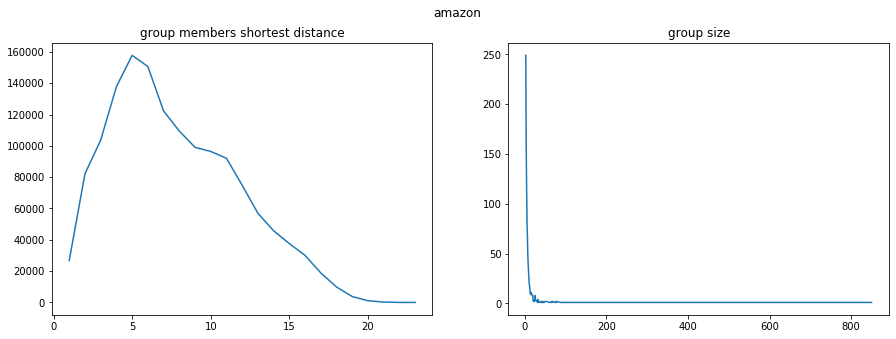

In [41]:
fig2, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5)) # two axes on figure
fig2.suptitle(dataset)
data = {
    'x': [ key for key, _ in stats.items() ],
    'y': [ size for _, size in stats.items() ],
}
ax1.set_title('group members shortest distance')
sns.lineplot(x='x', y='y', data=data, ax=ax1)
data = {
    'x': [ key for key, _ in group_size.items() ],
    'y': [ size for _, size in group_size.items() ],
}
ax2.set_title('group size')
sns.lineplot(x='x', y='y', data=data, ax=ax2)
fig2.savefig('{}.png'.format(dataset))

In [11]:
import json
from collections import defaultdict
movies = []
actor_cnt = defaultdict(int)
with open('movielens/movie_metadata_v3.jsonl', 'r') as f:
    for line in f.readlines():
        try:
            movie = json.loads(line)
            movies.append(movie)
            for actor in movie['actors']:
                actor_cnt[actor] += 1
        except:
            continue


In [12]:
len(movies)

4920

In [13]:
count_dist = []
for name, count in actor_cnt.items():
    count_dist.append(count)

In [15]:
stats = defaultdict(int)
for act, count in actor_cnt.items():
    stats[count] += 1

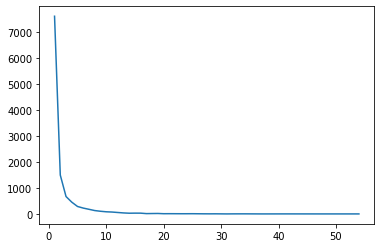

In [16]:
data = {
    'x': [ key for key, _ in stats.items() ],
    'y': [ size for _, size in stats.items() ],
}
sns.lineplot(x='x', y='y', data=data)

In [19]:
stats[1]

7598

In [20]:
print(len(actor_cnt))

11615


In [39]:
with open('meetup_v2/94101_5_100_valid_members.pkl', 'rb') as f:
    valid_members = pickle.load(f)
print(len(valid_members['valid']))

FileNotFoundError: [Errno 2] No such file or directory: 'meetup_v2/94101_5_100_valid_members.pkl'

In [43]:
df = pd.read_csv('ml-latest-small/ratings.csv')
movie_rating_stats = defaultdict(int)
user_rating_stats = defaultdict(int)
rating_stats = defaultdict(int)

for idx, row in df.iterrows():
    movie_rating_stats[row['movieId']] += 1
    rating_stats[row['rating']] += 1
    user_rating_stats[row['userId']] += 1


In [44]:
print(rating_stats)

defaultdict(<class 'int'>, {4.0: 26818, 5.0: 13211, 3.0: 20047, 2.0: 7551, 1.0: 2811, 4.5: 8551, 3.5: 13136, 2.5: 5550, 0.5: 1370, 1.5: 1791})


In [41]:
author2id = defaultdict(int)
paper2id = defaultdict(int)
conf2id = defaultdict(int)
member2freq = defaultdict(int)
papers = []
data = {}
cnt = 0
with open('aminer/dblp.txt', 'r') as f:
    for line in tqdm(f.readlines()):
        if '#' in line:
            if '*' == line[1]:
                if len(data) > 3 and 'authors' in data and len(data['authors']) >= 5 and len(data['authors']) <= 100:
                    papers.append(data)
                data = {}
                title = line.strip()[2:]
                if title not in paper2id:
                    paper2id[title] = len(paper2id)
                data['title'] = title
            elif '@' == line[1]:
                author_line = line.strip()[2:]
                authors = [a.strip() for a in author_line.split(',')]
                if len(authors) < 5 or len(authors) > 100:
                    continue
                for a in authors:
                    member2freq[a] += 1
                    if a not in author2id:
                        author2id[a] = len(author2id)
                data['authors'] = authors
            elif 'c' == line[1]:
                conf = line.strip()[2:]
                if conf not in conf2id:
                    conf2id[conf] = len(conf2id)
                data['conf'] = conf
            elif 't' == line[1]:
                year = line.strip()[2:]
                data['year'] = int(year)
                
if len(data) > 3 and 'authors' in data and len(data['authors']) >= 3:
    papers.append(data)

100%|██████████| 23847313/23847313 [01:00<00:00, 394094.94it/s]


In [42]:
papers.sort(key=lambda x: x['year'])

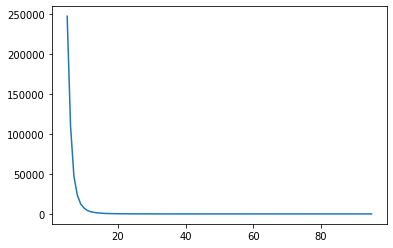

In [5]:
stats = defaultdict(int)
for p in papers:
    stats[len(p['authors'])] += 1
data = {
    'x': [ key for key, _ in stats.items() ],
    'y': [ size for _, size in stats.items() ],
}
sns.lineplot(x='x', y='y', data=data)

In [6]:
papers.sort(key=lambda x:x['year'])

In [28]:
papers[0], papers[-1]

({'title': 'Experiments in Chess.',
  'authors': ['J. Kister', 'P. Stein', 'S. Ulam', 'W. Walden', 'M. Wells'],
  'year': 1957,
  'conf': 'J. ACM'},
 {'title': 'Knowledge Graph Foundations.',
  'authors': ['Boris Villazón-Terrazas',
   'Nuria García-Santa',
   'Yuan Ren',
   'Alessandro Faraotti',
   'Honghan Wu',
   'Yuting Zhao',
   'Guido Vetere',
   'Jeff Z. Pan'],
  'year': 2017,
  'conf': 'Exploiting Linked Data and Knowledge Graphs in Large Organisations'})

In [37]:
with open('paper_author_edge.txt', 'w') as f:
    for p in papers:
        for a in p['authors']:
            f.write('{}\t{}\n'.format(paper2id[p['title']], author2id[a]))

with open('conf_paper_edge.txt', 'w') as f:
    for p in papers:
        f.write('{}\t{}\n'.format(paper2id[p['title']], conf2id[p['conf']]))

In [129]:
with open('aminer/preprocess_dblp.pkl', 'rb') as f:
    dblp = pickle.load(f)

papers = dblp['papers']
author2id = dblp['author2id']
paper2id = dblp['paper2id']
conf2id = dblp['conf2id']
paper2authors = dblp['paper2authors']
index2title = dblp['index2title']
citation_graph = dblp['citation_graph']

In [125]:
G = nx.Graph()

for p in tqdm(papers[:len(papers)//2]):

    p_id = 'p'+str(paper2id[p['title']])
    c_id = 'c'+str(conf2id[p['conf']])

    if not G.has_node(p_id):
        G.add_node(p_id)

    for n in citation_graph.neighbors(p['index']):
        neighbour_title = index2title[n]
        id_ = paper2id[neighbour_title]

        n_p_id = 'p'+str(id_)
        
        if not G.has_node(n_p_id):
            G.add_node(n_p_id)       
        
        G.add_edge(p_id, n_p_id)


    for a in p['authors']:
        a_id = 'a'+str(author2id[a])

        if not G.has_node(a_id):
            G.add_node(a_id)
        G.add_edge(p_id, a_id)

    if not G.has_node(c_id):
        G.add_node(c_id)
    G.add_edge(c_id, p_id)

100%|██████████| 231215/231215 [00:23<00:00, 9723.41it/s] 


In [75]:
matched = 0
stats = defaultdict(int)
for  p in tqdm(papers[len(papers)//2:]):
    count = 0
    for a in p['authors']:
        a_id = 'a'+str(author2id[a])
        if G.has_node(a_id):
            count += 1
    stats[count] += 1
    p_id = 'p'+str(paper2id[p['title']])
    c_id = 'c'+str(conf2id[p['conf']])
    for a in p['authors']:
        a_id = 'a'+str(author2id[a])
        if not G.has_node(p_id):
            G.add_node(p_id)
        if not G.has_node(a_id):
            G.add_node(a_id)
        G.add_edge(p_id, a_id)    
    if not G.has_node(c_id):
        G.add_node(c_id)
    G.add_edge(c_id, p_id)

100%|██████████| 231216/231216 [00:15<00:00, 15228.48it/s]


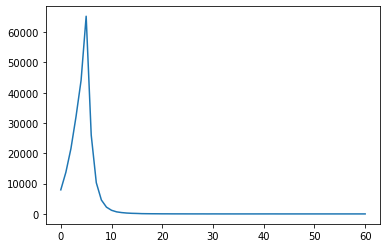

In [73]:
data = {
    'x': [ key for key, _ in stats.items() ],
    'y': [ size for _, size in stats.items() ],
}
fig, ax = plt.subplot()
sns.lineplot(x='x', y='y', data=data, ax=ax)


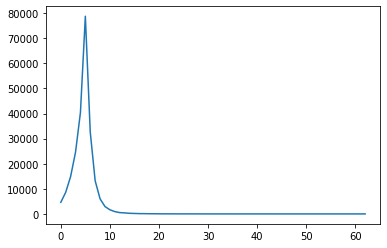

In [76]:
data = {
    'x': [ key for key, _ in stats.items() ],
    'y': [ size for _, size in stats.items() ],
}
fig, ax = plt.subplot()
sns.lineplot(x='x', y='y', data=data, ax=ax)

In [137]:
from src.aminer2 import create_subgraph, get_neighbour_nodes, graph2data
from copy import deepcopy

In [171]:
hit_stats = defaultdict(int)
pred_stats = defaultdict(int)
H = G.copy()
failed_cnt = 0
geometric_data = []
sub_graphs = []
for idx, paper in enumerate(papers[len(papers)//2:]):
    paper = deepcopy(paper)
    paper['title'] = paper2id[paper['title']]
    paper['authors'] = [ author2id[a] for a in paper['authors']]
    sub_G, hit, pred_cnt = create_subgraph(paper, H, cutoff=2)

    hit_stats[hit] += 1
    pred_stats[pred_cnt] += 1
    if sub_G is None:
        print('failed')
        continue

    geometric_data.append(graph2data(sub_G))
    sub_graphs.append(sub_G)
    print(len(sub_G.nodes))
    if idx > 5000:
        break

    p = paper
    p_id = 'p'+str(paper2id[p['title']])
    c_id = 'c'+str(conf2id[p['conf']])
    for a in p['authors']:
        a_id = 'a'+str(author2id[a])
        if not H.has_node(p_id):
            H.add_node(p_id)
#         for n in citation_graph.neighbors(p['index']):
#             neighbour_title = index2title[n]
#             id_ = paper2id[neighbour_title]
#             n_p_id = 'p'+str(id_)
#             if not H.has_node(n_p_id):
#                 H.add_node(n_p_id)       
#             H.add_edge(p_id, n_p_id)
        if not H.has_node(a_id):
            H.add_node(a_id)
        H.add_edge(p_id, a_id)
    if not H.has_node(c_id):
        H.add_node(c_id)
    H.add_edge(c_id, p_id)
    

124
88
42
failed
233
36
68
29
65
185
151
65
failed
30
150
1697
94
8
34
231
298
81
180
149
185
427
59
57
146
14
239
431
890
409
91
460
204
259
39
109
192
60
820
136
831
371
838
185
54
127
554
115
51
102
89
48
97
88
110
184
68
135
101
140
408
155
117
120
290
78
413
76
122
failed
91
144
352
108
127
276
146
171
242
93
38
127
10
64
297
25
92
263
78
51
33
22
1417
739
failed
1663
12
failed
8
3333
216
97
69
63
7
3190
146
157
47
1913
22
76
33
64
513
60
100
575
1103
52
140
347
223
602
890
96
58
15
1135
927
323
360
477
48
12
1265
95
421
217
31
180
20
393
322
609
117
failed
16
182
108
715
70
958
713
305
313
64
failed
191
254
707
214
293
61
333
86
26
30
964
401
241
135
210
145
89
89
89
116
24
100
257
89
129
22
101
59
162
133
222
67
119
105
98
failed
56
115
failed
106
153
failed
101
232
180
84
150
325
148
1038
548
53
41
93
169
52
288
112
517
250
159
99
330
315
110
failed
15
75
132
185
12
15
173
607
72
22
179
44
133
172
203
100
152
141
85
142
31
74
7
65
224
472
156
259
141
343
285
12
100
41
failed
25

KeyboardInterrupt: 

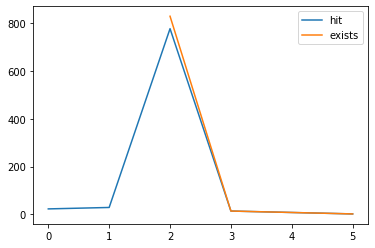

In [172]:
data = {
    'x': [ key for key, _ in hit_stats.items() ],
    'y': [ size for _, size in hit_stats.items() ],
    'type': ['hit']*len(hit_stats.keys()),
}
for key,size in pred_stats.items():
    data['x'].append(key)
    data['y'].append(size)
    data['type'].append('exists')
sns.lineplot(x='x', y='y', hue='type',data=data)

In [169]:
data_idx = 4
print(geometric_data[data_idx].x[geometric_data[data_idx].x[:, 2] == 0])

tensor([[ 11421,      0,      0],
        [479321,      0,      0],
        [479320,      0,      0],
        [  1135,      0,      0],
        [144549,      0,      0],
        [488076,      0,      0],
        [488078,      0,      0],
        [113595,      0,      0],
        [ 40707,      0,      0],
        [406504,      0,      0],
        [ 40708,      0,      0],
        [290560,      0,      0],
        [563840,      0,      0],
        [279369,      0,      0],
        [406505,      0,      0],
        [ 66559,      0,      0],
        [406503,      0,      0],
        [ 40705,      0,      0],
        [488077,      0,      0],
        [ 40706,      0,      0],
        [ 66478,      0,      0],
        [ 40704,      0,      0],
        [ 40709,      0,      0],
        [406502,      0,      0],
        [406501,      0,      0]])


In [165]:
print(sub_graphs[data_idx].nodes)

['p1058897', 'p1057571', 'p1060872', 'p85247', 'p1061704', 'p1058510', 'p1499815', 'p1060305', 'p1321945', 'p1057898', 'p1060369', 'p127355', 'p127690', 'p772761', 'p771498', 'p772682', 'p772799', 'p85214', 'p1057203', 'p1059547', 'p1503879', 'p1504164', 'p1058547', 'p1060660', 'p1058162', 'p1057679', 'p1504889', 'p1061123', 'p127820', 'p1060764', 'p127893', 'p1500570', 'p1058422', 'p1061199', 'p1061386', 'p186867', 'p576998', 'p1501842', 'p1500845', 'p1501079', 'p1059115', 'p1058419', 'p1363941', 'p1057787', 'p1060362', 'p1057962', 'p1060212', 'p1058595', 'p772191', 'p1499952', 'p1058526', 'p1059149', 'p1061628', 'p1058821', 'p1058425', 'p622475', 'p85300', 'p1057313', 'p1060217', 'p1059081', 'p1059431', 'p1499734', 'p1059425', 'p1059147', 'p1058745', 'p1061459', 'p1057742', 'p1059649', 'p1061198', 'p1061964', 'p1502323', 'p1057860', 'p1060635', 'p1061698', 'p1057419', 'p1059104', 'p1504008', 'p1058015', 'p1061525', 'p1497521', 'p1505201', 'p85217', 'p85365', 'p771962', 'p771057', 'p4

In [74]:
from src.aminer2 import get_neighbour_nodes

In [80]:
test = nx.Graph()
for node_id in range(10):
    test.add_node(node_id)

test.add_edge(1,2);test.add_edge(0,1)
test.add_edge(1,3);test.add_edge(2,4)
test.add_edge(4,6);test.add_edge(2,5)
test.add_edge(5,7);test.add_edge(7,9)

In [81]:
print(get_neighbour_nodes(test, 1, cutoff=2))

[1, 4, 5, 2, 1, 0, 1, 3]


In [2]:
import pickle

In [6]:
from src.yahoo import init_graph_with_group
import networkx as nx

In [22]:
G, group_mappings = init_graph_with_group('small')

10001


In [8]:
len(G.nodes), len(G.edges)

(187080, 244837)

In [32]:
list(H.neighbors('g10000'))

['u21241',
 'u39714',
 'u54679',
 'u109554',
 'u112214',
 'u125155',
 'u177082',
 'u177083',
 'u177084',
 'u177085']

In [27]:
name2id = {}
for n in G.nodes:
    if n[0] == 'u':
        name2id[n] = 'u' +str(len(name2id)+1)
H = nx.relabel.relabel_nodes(G, name2id)


In [33]:
with open('data/yahoo-group/ydata-ygroups-user-group-10000-membership-graph-v1_0.txt', 'w') as f:
    f.write('%d %d\n' % (len(H.nodes), len(H.edges)))
    for idx in range(10000):
        neighbors = list(H.neighbors('g'+str(idx+1)))
        f.write(' '.join(neighbors)+'\n')
    offset = 10000
    for idx in range(len(name2id)):
        neighbors = list(H.neighbors('u'+str(idx+1)))
        f.write(' '.join(neighbors)+'\n')

In [45]:
from torch_geometric.utils.convert import to_networkx
from src.meetup import Meetup
from src.skipgram import data_to_networkx_, extract_node_type, sample_node_neighbour_hops, generate_batch

In [2]:
dataset = Meetup()

Processing...
Done!


In [36]:
sub_G = data_to_networkx_(dataset[0])

In [46]:
inputs, labels, negative = generate_batch(sub_G, 128, 0, len(dataset.user2id), neg_num=2)

In [49]:
from src.skipgram import SkipGramNeg
import torch

In [50]:
model = SkipGramNeg(len(dataset.user2id), 8)
loss = model(torch.from_numpy(inputs), torch.from_numpy(labels), torch.from_numpy(negative))

tensor(1.3863, grad_fn=<NegBackward>)

In [105]:
import torch
from torch_geometric.data import DataLoader
from src.aminer import Aminer

In [106]:
data = torch.load('processed/dblp_v1/processed/dblp_3_0.8_5_3_983_v2.pt')
datasets = Aminer()
trainer = DataLoader(datasets, batch_size=5)

Processing...
processed/dblp_v1/processed
length: 7297
update
Done!
processed/dblp_v1/processed
length: 7297
update


In [60]:
author_node_idx = data.x[:, -1] == 0
paper_idx = data.x[ :, 0 ] == data.titleid[0]

candidate_idx = author_node_idx & (data.x[:, 1 ] == 1)
# not label not known users and node type = user
negative_node_idx = (data.y == 0) & (~candidate_idx) & (author_node_idx)
target_node = data.x[ (data.y==1) ]

candidate_node = data.x[ candidate_idx ]
negative_node = data.x[ negative_node_idx ]

In [67]:
from src.layers import StackedGCNDBLP
model = StackedGCNDBLP(
                   author_size=874608,#len(author2id),
                   paper_size=3605603,#len(paper2id),
                   conf_size=12770, output_channels=5)

In [69]:
outputs = model(data.edge_index, data.x)

In [71]:
negative_embed = outputs[ negative_node_idx ]
candidate_embed = outputs[ candidate_idx ]
target_embed = outputs[ data.y==1 ]

In [82]:
latent = candidate_embed.sum(0)
# target_embed[0]*latent - latent*negative_embed

In [126]:
pos = (torch.mm(latent.unsqueeze(-1).T, target_embed.T ) - 1)**2
# torch.dot(target_embed[0],  latent)
neg = torch.mm(negative_embed, latent.unsqueeze(-1))**2

In [101]:
loss = pos.sum()+neg.sum()

In [103]:
loss.backward()

None


In [99]:
mse_loss(pos, 1)

NameError: name 'mse_loss' is not defined

In [107]:
batch = next(iter(trainer))

In [121]:
outputs = model(batch.edge_index, batch.x)

acc_loss = 0
N = 0
for batch_idx in range(batch_size):
    paper_idx = (batch.batch == batch_idx)
    data = outputs[paper_idx]
    print(len(data))

    author_node_idx = (batch.x[:, -1] == 0) & paper_idx
    candidate_idx = author_node_idx & (batch.x[:, 1 ] == 1)
    # not label not known users and node type = user
    negative_node_idx = (batch.y == 0) & (~candidate_idx) & (author_node_idx)

    negative_embed = outputs[ negative_node_idx ]
    candidate_embed = outputs[ candidate_idx ]
    target_embed = outputs[ (batch.y==1) & paper_idx]
    
    latent = candidate_embed.sum(0)
    pos = (torch.mm(target_embed, latent.unsqueeze(-1)) - 1)**2
    # torch.dot(target_embed[0],  latent)
    neg = torch.mm(negative_embed, latent.unsqueeze(-1))**2
    N += (len(pos) + len(neg))
    acc_loss += pos.sum()+neg.sum()

46
125
41
25
38


In [123]:
loss = acc_loss / (N*2)

In [124]:
print(loss)

tensor(4471.3730, grad_fn=<DivBackward0>)
